In [1]:
import proposal as pp
import numpy as np
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sys 
sys.path.append('../')
from helper_functions_multi import get_angle_deviation
import os
import shutil

In [2]:
data_dir = 'data/deflection_method_shower_dist/'
os.system('mkdir -p {}'.format(data_dir))

plot_dir = 'plots/deflection_method_shower_dist/'
os.system('mkdir -p {}'.format(plot_dir))

save_plot = True

In [3]:
table_path = "/Users/pgutjahr/.cache/PROPOSAL" # macbook pro
# table_path = "/net/nfshome/home/pgutjahr/.cache/PROPOSAL" # vollmond

In [4]:
# remove old tables
if False:
    print(f'Removing {table_path}')
    shutil.rmtree(table_path)

In [5]:
if 'table_path' in locals():
    os.makedirs(table_path, exist_ok=True)

In [21]:
deflection = [
    'bremsginneken', # 'bremstsaiapproximation', 
    'ioniznaive',
    'photoginneken', # 'photoborogpetrukhin',
    'epairginneken'] ### same as default
    
e_cut = 500 # np.inf 
v_cut = 0.05 # 1e-5
cont_rand = True
scattering_method = "moliere" # "highland"
# deflection_type = "m_scat+stochastic"
    
rnd_seed = 71530

interpol_nodes = 100 # 200

initial_direction = [0, 0, 1]

beta_brems = 1.0
beta_ioniz = 1.0
beta_epair = 1.0
beta_photonuclear = 1.0
beta_multiplescatter = 1.0

In [22]:
pp.InterpolationSettings.tables_path = table_path   # version 7
    
pp.InterpolationSettings.nodes_dndx_e = interpol_nodes
pp.InterpolationSettings.nodes_dndx_v = interpol_nodes

pp.RandomGenerator.get().set_seed(rnd_seed)
args = {
        "particle_def": pp.particle.MuMinusDef(),
        "target": pp.medium.Ice(),
        "interpolate": True,
        "cuts": pp.EnergyCutSettings(e_cut, v_cut, cont_rand)
        }

cross = pp.crosssection.make_std_crosssection(**args)

multiple_scatter = pp.make_multiple_scattering(scattering_method, args["particle_def"], args["target"], cross, True)
stochastic_deflect = []
for d in deflection:
    stochastic_deflect.append(pp.make_stochastic_deflection(d, 
    args["particle_def"], args["target"]))


collection = pp.PropagationUtilityCollection()
collection.displacement = pp.make_displacement(cross, True)
collection.interaction = pp.make_interaction(cross, True)
collection.time = pp.make_time(cross, args["particle_def"], True)
collection.decay = pp.make_decay(cross, args["particle_def"], True)

collection.scattering = pp.scattering.ScatteringMultiplier(
    multiple_scatter, 
    stochastic_deflect, 
    beta_multiplescatter, 
    [(pp.particle.Interaction_Type.brems, beta_brems), (pp.particle.Interaction_Type.ioniz, beta_ioniz), 
    (pp.particle.Interaction_Type.epair, beta_epair), (pp.particle.Interaction_Type.photonuclear, beta_photonuclear)])


# collection.scattering = pp.scattering.ScatteringMultiplier(
#     multiple_scatter, 
#     beta_multiplescatter)

utility = pp.PropagationUtility(collection = collection)
detector = pp.geometry.Sphere(pp.Cartesian3D(0,0,0), 1e20) # version 7
density_distr = pp.density_distribution.density_homogeneous(args["target"].mass_density)


prop = pp.Propagator(args["particle_def"], [(detector, utility, density_distr)])

init_state = pp.particle.ParticleState()
init_state.position = pp.Cartesian3D(0, 0, 0) # version 7
init_state.direction = pp.Cartesian3D(initial_direction[0], initial_direction[1], initial_direction[2]) # version 7


# Run simulation

In [23]:
E_i = 1e9 # in MeV
E_f = 1e6 # in MeV
n_events = 100

max_dist = 1e9 # in cm

tracks = []
for i in tqdm(range(n_events)):
    init_state.energy = E_i # initial energy in MeV
    track = prop.propagate(init_state, max_distance = max_dist, min_energy = E_f) # max_dist=1e9
    tracks.append(track)

100%|██████████| 100/100 [00:03<00:00, 26.00it/s]


In [ ]:
tracks[0].track_directions()[-1].spherical_coordinates


[0.99999999999989, -2.0339012404323062, 0.0011121568071021707]

In [9]:
tracks[0].track_directions()[-1].spherical_coordinates

[0.9999999999999454, 1.2279532949320213, 0.00015286988569512602]

In [24]:
tracks_zenith = np.array([])
tracks_azimuth = np.array([])
tracks_x = np.array([])
tracks_y = np.array([])
tracks_z = np.array([])
tracks_pos_x = np.array([])
tracks_pos_y = np.array([])
tracks_pos_z = np.array([])
tracks_propagated_distances = np.array([])
tracks_deflection = np.array([])
for track in tqdm(tracks):
    tracks_zenith = np.append(tracks_zenith, track.track_directions()[-1].spherical_coordinates[2])
    tracks_azimuth = np.append(tracks_azimuth, track.track_directions()[-1].spherical_coordinates[1])
    tracks_x = np.append(tracks_x, track.track_directions()[-1].x)
    tracks_y = np.append(tracks_y, track.track_directions()[-1].y)
    tracks_z = np.append(tracks_z, track.track_directions()[-1].z)
    tracks_pos_x = np.append(tracks_pos_x, track.track_positions()[-1].x)
    tracks_pos_y = np.append(tracks_pos_y, track.track_positions()[-1].y)
    tracks_pos_z = np.append(tracks_pos_z, track.track_positions()[-1].z)
    tracks_propagated_distances = np.append(tracks_propagated_distances, track.track_propagated_distances()[-1])
    tracks_deflection = np.append(tracks_deflection, get_angle_deviation(
        track.track_directions()[0].spherical_coordinates[1],
        track.track_directions()[0].spherical_coordinates[2],
        track.track_directions()[-1].spherical_coordinates[1],
        track.track_directions()[-1].spherical_coordinates[2],
        dtype='float64'
    ))

100%|██████████| 100/100 [00:02<00:00, 35.85it/s]


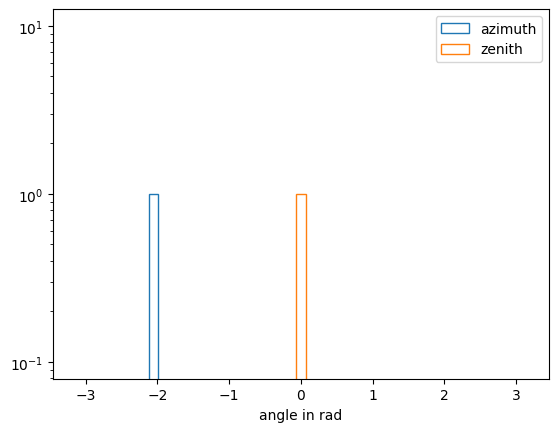

In [11]:
bins = np.linspace(-np.pi, np.pi, 50)
plt.hist(tracks_azimuth, bins=bins, histtype='step', label='azimuth')
plt.hist(tracks_zenith, bins=bins, histtype='step', label='zenith')
plt.xlabel('angle in rad')
plt.yscale('log')
plt.legend()

/var/folders/pc/v24ktpt115qc820xwmy79pv40000gn/T/ipykernel_4337/4238873149.py:2: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  n = plt.hist2d(tracks_x, tracks_y, bins=bins, norm=mpl.colors.LogNorm(), cmap=mpl.cm.gray)
/var/folders/pc/v24ktpt115qc820xwmy79pv40000gn/T/ipykernel_4337/4238873149.py:2: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  n = plt.hist2d(tracks_x, tracks_y, bins=bins, norm=mpl.colors.LogNorm(), cmap=mpl.cm.gray)


1.0

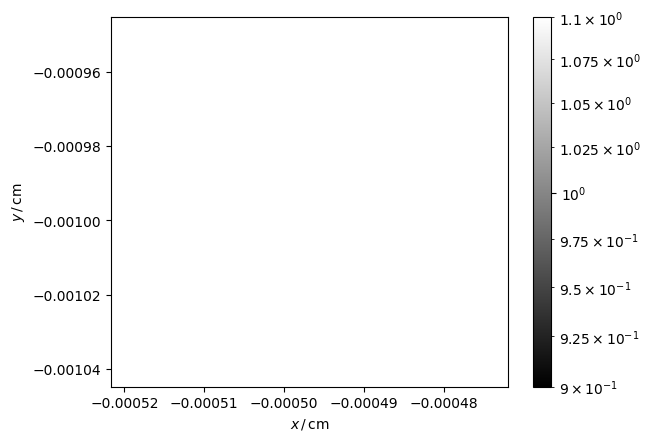

In [12]:
bins = (np.linspace(min(tracks_x), max(tracks_x), 50), np.linspace(min(tracks_y), max(tracks_y), 50))
n = plt.hist2d(tracks_x, tracks_y, bins=bins, norm=mpl.colors.LogNorm(), cmap=mpl.cm.gray) 
plt.colorbar()
plt.xlabel('$x\,/\,$cm')
plt.ylabel('$y\,/\,$cm')
plt.scatter(0, 0, color='red')   
np.max(n[0])

In [115]:
tracks_propagated_distances

array([2284075.78964152, 1918963.50606242, 2036632.77906299,
       2262568.15903133, 1224020.82770425, 2331156.35967805,
       1702587.92859942, 2102761.58371951, 1843600.89739061,
       1804210.00563016, 2009739.1176833 , 1485715.66664515,
       1857086.53816851, 1479458.75598008, 1542821.57396725,
       1054840.33744235, 1837403.2486176 , 1596770.84206398,
       1312830.67810782, 1739534.088529  , 1283894.4732961 ,
       1535199.83987977, 1308282.3241635 , 1984218.76930349,
       2020681.6177632 , 1592683.678648  , 1941403.5539749 ,
       1288467.28870348, 1691133.52568581, 1764564.56601706,
       1618553.7341151 , 1618755.37463066, 2088165.63351907,
       1814046.73461698, 1524831.61585954, 2312844.28753252,
       1125810.33877819, 1398342.63709364, 1141136.6146752 ,
       1527056.60813059, 1674479.15788988, 1868429.82946982,
       1703981.62421914, 1327856.80706835, 1521055.5695893 ,
       1554731.67878608, 1159400.66500787, 1159609.33573643,
       2008527.67487889,

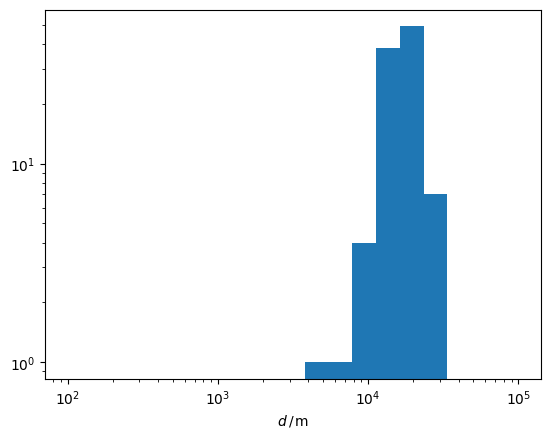

In [118]:
bins = np.logspace(2, 5, 20)
plt.hist(np.array(tracks_propagated_distances)/100, bins=bins)
plt.yscale('log')
plt.xlabel('$d\,/\,$m')
plt.xscale('log')

In [13]:
def d_shower(x, y, in_meter=True):
    d = np.sqrt(x**2 + y**2)
    if in_meter:
        return d / 100 # distance in meter
    else:
        return  d 

Text(0.5, 0, 'lateral displacement in cm')

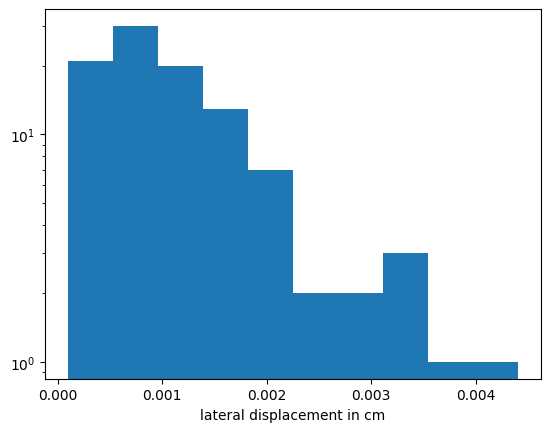

In [19]:
plt.hist(d_shower(tracks_x, tracks_y, in_meter=False))
plt.yscale('log')
plt.xlabel('lateral displacement in cm')

Text(0.5, 0, '$\\theta\\,/\\,°$')

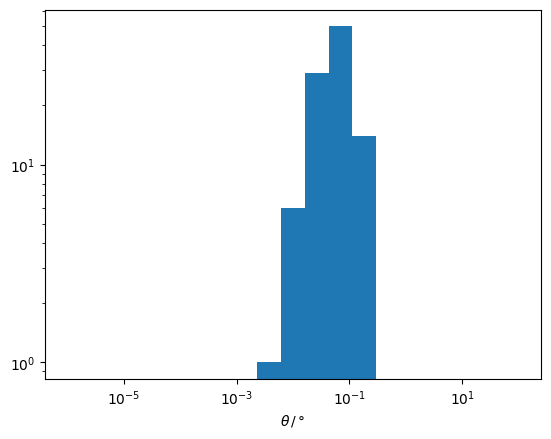

In [20]:
bins = np.logspace(-6, 2, 20)
plt.hist(np.rad2deg(tracks_deflection), bins=bins)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\theta\,/\,°$')

Text(0.5, 0, 'lateral displacement in cm')

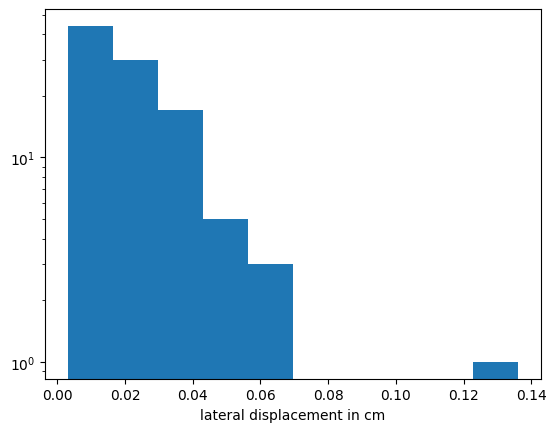

In [25]:
plt.hist(d_shower(tracks_x, tracks_y, in_meter=False))
plt.yscale('log')
plt.xlabel('lateral displacement in cm')

Text(0.5, 0, '$\\theta\\,/\\,°$')

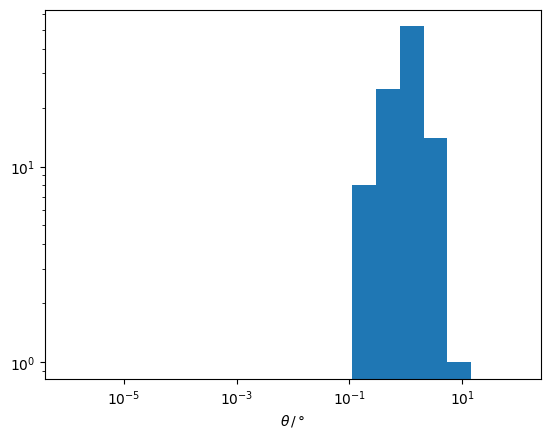

In [26]:
bins = np.logspace(-6, 2, 20)
plt.hist(np.rad2deg(tracks_deflection), bins=bins)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\theta\,/\,°$')

## save data

In [133]:
# '''
df = pd.DataFrame()
df['x'] = tracks_x
df['y'] = tracks_y
df['z'] = tracks_z
df['pos_x'] = tracks_pos_x
df['pos_y'] = tracks_pos_y
df['pos_z'] = tracks_pos_z
df['zenith'] = tracks_zenith
df['azimuth'] = tracks_azimuth
df['propagated_distances'] = tracks_propagated_distances
df['deflection'] = tracks_deflection

key = 'E{}_{}_v_cut{}_e_cut{}'.format(int(E_i/1e3), scattering_method, v_cut, e_cut).replace('.', '_') # E_i in GeV
df.to_hdf(data_dir + 'proposal.hdf5', key=key)
print(key)
# '''

E1000000_moliere_v_cut0_05_e_cut500


## read data

In [132]:
df = pd.read_hdf(data_dir + 'proposal.hdf5', key=key)
df

,x,y,z,pos_x,pos_y,pos_z,zenith,azimuth,propagated_distances,deflection
0,0.000429,0.000223,1.000000,-23.873137,68.470705,2.284076e+06,0.000484,0.478161,2.284076e+06,0.000484
1,-0.000930,-0.000713,0.999999,-70.064454,-12.439169,1.918963e+06,0.001172,-2.487667,1.918964e+06,0.001172
2,0.001416,0.000425,0.999999,604.713131,-15.218533,2.036632e+06,0.001479,0.291396,2.036633e+06,0.001479
3,-0.000589,0.000291,1.000000,20.176724,302.237134,2.262568e+06,0.000657,2.682381,2.262568e+06,0.000657
4,-0.000211,0.000924,1.000000,21.238000,51.762025,1.224021e+06,0.000948,1.795281,1.224021e+06,0.000948
...,...,...,...,...,...,...,...,...,...,...
95,0.000479,0.000689,1.000000,16.547724,100.837430,1.330293e+06,0.000840,0.962944,1.330293e+06,0.000840
96,-0.000176,-0.000494,1.000000,-34.512308,-238.261085,1.738825e+06,0.000525,-1.912331,1.738825e+06,0.000525
97,-0.001511,-0.001058,0.999998,-132.013795,-81.125442,1.670926e+06,0.001844,-2.530660,1.670926e+06,0.001844
98,0.000302,-0.000080,1.000000,13.280076,-8.053183,2.036971e+06,0.000312,-0.258522,2.036971e+06,0.000312


# Plot all 